In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import tensorflow as tf
from tensorflow import keras as k
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
#read csv
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_validation = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#X_train,Y_train,X_test,Y_test = df_split(df,0.75)
Y_train = df["label"]
X_train = df.drop(labels = ["label"],axis = 1) 
Y_train = to_categorical(Y_train, num_classes = 10)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)


In [26]:
train_datagenerator = k.preprocessing.image.ImageDataGenerator(
rescale= 1/255,
rotation_range= 20,
width_shift_range= 0.1,
height_shift_range= 0.1,
shear_range= 0.1,
zoom_range= 0.1,
fill_mode= 'nearest'
)

test_datagenerator = k.preprocessing.image.ImageDataGenerator(
rescale= 1/255
)

train_generator = train_datagenerator.flow(
X_train,
Y_train,
batch_size = 128
)
test_generator = test_datagenerator.flow(
X_test,
Y_test,
batch_size = 128)


In [14]:
#Model1
Model1 = k.models.Sequential([
    k.layers.Conv2D(32,(5,5),activation = 'relu',padding = 'same',input_shape = (28,28,1)),
    k.layers.MaxPooling2D(2,2),
    k.layers.Conv2D(64,(5,5),padding = 'valid',activation = 'relu'),
    k.layers.MaxPooling2D(2,2),
    k.layers.Dropout(0.25),
    k.layers.Conv2D(128,(3,3),padding = 'same',activation = 'relu'),
    k.layers.MaxPooling2D(2,2),
    k.layers.Dropout(0.25),
    k.layers.Flatten(),
    k.layers.Dense(256,activation = 'relu'),
    k.layers.Dense(84,activation = 'relu'),
    k.layers.Dropout(0.25),
    k.layers.Dense(10,activation = 'softmax')
])

Model1.compile(
optimizer = 'adam',
loss = 'categorical_crossentropy',
metrics = ['accuracy'])



In [27]:
#Model2
inputs = k.layers.Input(shape = (28,28,1), dtype = 'float32')
X = k.layers.ZeroPadding2D(padding = (2,2))(inputs)
X = k.layers.Conv2D(3,(3,3),padding = 'same')(X)
base_model = k.applications.VGG16(
include_top= False,
input_shape= (32,32,3)
)
base_model.trainable = False
X = base_model(X,training = False)
X = k.layers.Flatten()(X)
X = k.layers.Dense(512,activation = 'relu')(X)
X = k.layers.Dense(256,activation = 'relu')(X)
X = k.layers.Dropout(0.25)(X)
X = k.layers.Dense(128,activation = 'relu')(X)
X = k.layers.Dropout(0.5)(X)
outputs = k.layers.Dense(10,activation = 'softmax')(X)

Model2 = k.Model(inputs,outputs)

Model2.compile(
optimizer = 'adam',
loss = 'categorical_crossentropy',
metrics = ['accuracy'])


In [42]:
#Model3
Model3 = k.models.Sequential([
    k.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = (28,28,1)),
    k.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu'),
    k.layers.MaxPool2D(2,2),
    k.layers.Dropout(0.25),
    k.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'),
    k.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'),
    k.layers.MaxPool2D(2,2),
    k.layers.Dropout(0.25),
    k.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'),
    k.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same',activation ='relu'),
    k.layers.MaxPool2D(2,2),
    k.layers.Dropout(0.25),
    k.layers.Flatten(),
    k.layers.Dense(256,activation = 'relu'),
    k.layers.BatchNormalization(),
    k.layers.Dropout(0.5),
    k.layers.Dense(10,activation = 'softmax')
    
])

Model3.compile(
optimizer = 'adam',
loss = 'categorical_crossentropy',
metrics = ['accuracy'])

In [43]:
#callbacks
class accuracyCallback(k.callbacks.Callback):
    def on_epoch_end(self,epoch,logs = {}):
        if(logs.get('val_accuracy') >= 0.998):
            self.model.stop_training = True
callback1 = accuracyCallback()


callback2 = k.callbacks.ReduceLROnPlateau(
monitor = 'val_accuracy',
patience= 3,
verbose = 1,
factor = 0.5,
min_lr=1e-6
)





hist = Model3.fit_generator(
train_generator,
epochs = 50,
validation_data= test_generator,
callbacks= [callback1,callback2])

#Model1.evaluate(X_test,Y_test,verbose=2)

Epoch 1/50
296/296 [==============================] - 17s 56ms/step - loss: 0.6099 - accuracy: 0.7946 - val_loss: 0.3147 - val_accuracy: 0.9695
Epoch 2/50
296/296 [==============================] - 17s 57ms/step - loss: 0.1633 - accuracy: 0.9498 - val_loss: 0.1248 - val_accuracy: 0.9650
Epoch 3/50
296/296 [==============================] - 16s 54ms/step - loss: 0.1228 - accuracy: 0.9628 - val_loss: 0.0450 - val_accuracy: 0.9893
Epoch 4/50
296/296 [==============================] - 16s 56ms/step - loss: 0.0974 - accuracy: 0.9698 - val_loss: 0.0525 - val_accuracy: 0.9871
Epoch 5/50
296/296 [==============================] - 17s 57ms/step - loss: 0.0897 - accuracy: 0.9732 - val_loss: 0.0412 - val_accuracy: 0.9890
Epoch 6/50
296/296 [==============================] - 16s 55ms/step - loss: 0.0778 - accuracy: 0.9766 - val_loss: 0.0384 - val_accuracy: 0.9905
Epoch 7/50
296/296 [==============================] - 16s 53ms/step - loss: 0.0711 - accuracy: 0.9781 - val_loss: 0.0450 - val_accuracy:

296/296 [==============================] - 17s 57ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0148 - val_accuracy: 0.9960
Epoch 47/50
296/296 [==============================] - 16s 53ms/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.0148 - val_accuracy: 0.9960
Epoch 48/50
296/296 [==============================] - 16s 53ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0148 - val_accuracy: 0.9960
Epoch 49/50
296/296 [==============================] - 17s 57ms/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 0.0148 - val_accuracy: 0.9960
Epoch 50/50
296/296 [==============================] - 16s 53ms/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.0148 - val_accuracy: 0.9960


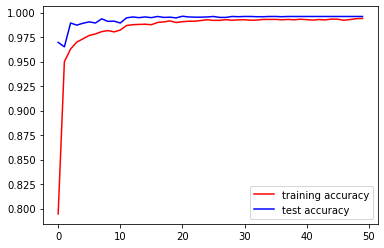

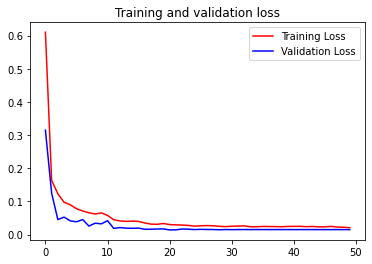

In [44]:
acc = hist.history['accuracy']
loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs,acc,'r',label = 'training accuracy')
plt.plot(epochs,val_acc,'b',label = 'test accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
df_validation = df_validation.values.reshape(-1,28,28,1)
results = Model3.predict(df_validation)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name = 'Label')
submission = pd.concat([pd.Series(range(1,28001),name = 'ImageId'),results],axis = 1)
submission.to_csv('Submission_M3.csv',index = False)